In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.layers import Dense, LSTM, Embedding, Dropout, Activation, Input
from keras.models import Model
import matplotlib.pyplot as plt
import csv
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

2023-12-12 23:34:16.030788: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 23:34:16.068728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 23:34:16.068763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 23:34:16.069648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 23:34:16.074274: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-12 23:34:16.074617: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Load data
df_train = pd.read_csv('data/twitter_training.csv', header=None)
df_train.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
label_to_idx = {'Irrelevant': 0, 'Negative': 1, 'Neutral': 0, 'Positive': 2}

In [4]:
# Find out number of different words in training set
words = set()
for sentence in df_train[3]:
    for word in str(sentence).split():
        words.add(word)
len(words)

82367

In [5]:
sorted(words)

['!',
 '!!',
 '!!!',
 '!!!!',
 '!!!!!',
 '!!!!!!!',
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',
 '!!!!!.',
 '!!!!.',
 '!!!.',
 '!!!..Enjoy',
 '!!!????',
 '!!.',
 '!"',
 '!.',
 '!=',
 '!?',
 '!Call',
 '!artist',
 '!bans',
 '!commandes',
 '!commands',
 '!giveaway',
 '!lurk',
 '!org',
 '!pat',
 '

In [6]:
# Since the above approach doesn't seem to be promising, continue with embeddings from glove-50
def read_glove_file(filename = 'glove.6B.50d.txt'):
    with open(filename, 'r') as f:
        words = set()
        words_to_vec_map = dict()
        for line in f:
            # Remove extra white spaces and split the line
            li = line.strip().split()
            words.add(li[0])
            words_to_vec_map[li[0]] = np.array(li[1:], dtype=np.float64)
    idx_to_words = dict()
    words_to_idx = dict()
    i = 1
    for word in sorted(words):
        words_to_idx[word] = i
        idx_to_words[i] = word
        i += 1
    return words_to_vec_map, words_to_idx, idx_to_words

In [7]:
words_to_vec_map, words_to_idx, idx_to_words = read_glove_file()

In [8]:
temp_word = "hello"
temp_idx = 289846
print(f"The word '{temp_word}' has index {words_to_idx[temp_word]}")
print(f"{temp_idx}th word is {idx_to_words[temp_idx]}")

The word 'hello' has index 176468
289846th word is potatos


In [9]:
maxLen = len(max(df_train[3], key=lambda x:len(str(x).strip().split())).strip().split())
maxLen

198

In [10]:
def preprocess_text(txt):
    review = re.sub('[^a-zA-Z]', ' ', txt)
    review = review.lower()
    review = review.split()

    # review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    # Don't stem
    review = [word for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review

def load_data(label_to_idx, csv_file = 'data/twitter_training.csv'):
    X = []
    y = []
    with open(csv_file, 'r') as f:
        csvReader = csv.reader(f)
        for row in csvReader:
            if (row[2]=="Irrelevant"): continue
            txt = row[3]
            txt = preprocess_text(txt)
            X.append(txt)
            y.append(label_to_idx[row[2]])
    X = np.asarray(X)
    y = np.asarray(y, dtype=int)
    return X, y

In [11]:
X_train, y_train = load_data(label_to_idx, 'data/twitter_training.csv')
X_val, y_val = load_data(label_to_idx, 'data/twitter_validation.csv')

In [12]:
def sentence_to_indices(X, words_to_idx ,maxLen):
    m = X.shape[0]
    X_out = np.zeros((m, maxLen))
    for i in range(m):
        li = X[i].lower().strip().split()
        j = 0
        for w in li:
            if (j >= maxLen): break
            if w in words_to_idx.keys():
                X_out[i,j] = words_to_idx[w]
            j += 1
    return X_out

In [13]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_size, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(input_dim = vocab_size, output_dim = emb_dim, trainable = False)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [14]:
X_train_indices = sentence_to_indices(X_train, words_to_idx, maxLen)
X_val_indices = sentence_to_indices(X_val, words_to_idx, maxLen)

In [15]:
def convert_to_one_hot(y, C = 3):
    return np.eye(C)[y.reshape(-1)]

In [16]:
y_train_oh = convert_to_one_hot(y_train, 3)
y_val_oh = convert_to_one_hot(y_val, 3)

In [17]:
y_train_oh[100]

array([0., 1., 0.])

In [18]:
def build_model(input_shape, words_to_vec_map, words_to_idx):
    sentence_indices = Input(shape = input_shape)

    embedding_layer = pretrained_embedding_layer(words_to_vec_map, words_to_idx)

    embeddings = embedding_layer(sentence_indices)

    X = LSTM(units=128, return_sequences=True)(embeddings)

    X = Dropout(rate = 0.5)(X)

    X = LSTM(units = 128, return_sequences=False)(X)

    X = Dropout(rate = 0.5)(X)

    X = Dense(units= 3)(X)

    X = Activation('softmax')(X)

    model = Model(inputs = sentence_indices, outputs = X)

    return model

In [32]:
model = build_model((maxLen, ), words_to_vec_map, words_to_idx)

In [33]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [34]:
history = model.fit(X_train_indices, y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50


2334/2334 [==============================] - 313s 133ms/step - loss: 1.0839 - accuracy: 0.4188
Epoch 2/50
2334/2334 [==============================] - 387s 166ms/step - loss: 1.0828 - accuracy: 0.4192
Epoch 3/50
2334/2334 [==============================] - 387s 166ms/step - loss: 1.0827 - accuracy: 0.4192
Epoch 4/50
2334/2334 [==============================] - 386s 166ms/step - loss: 1.0838 - accuracy: 0.4185
Epoch 5/50
2334/2334 [==============================] - 386s 165ms/step - loss: 1.0825 - accuracy: 0.4192
Epoch 6/50
2334/2334 [==============================] - 386s 166ms/step - loss: 1.0822 - accuracy: 0.4191
Epoch 7/50
2334/2334 [==============================] - 387s 166ms/step - loss: 1.0813 - accuracy: 0.4209
Epoch 8/50
2334/2334 [==============================] - 1441s 618ms/step - loss: 1.0830 - accuracy: 0.4191
Epoch 9/50
2334/2334 [==============================] - 1694s 726ms/step - loss: 1.0827 - accuracy: 0.4192
Epoch 10/50
2334/2334 [==============================] 

In [35]:
model.evaluate(X_val_indices, y_val_oh)

32/32 [==============================] - 5s 64ms/step - loss: 1.0693 - accuracy: 0.4570


[1.0692517757415771, 0.4569999873638153]

In [36]:
model.save("model_one_hot.h5")

/home/dcf-02/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


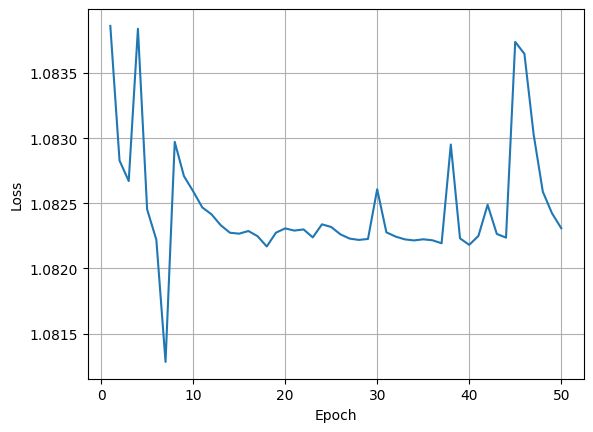

In [44]:
lss = history.history['loss']
epochs = np.array(list(range(1, 51)))
plt.plot(epochs, lss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

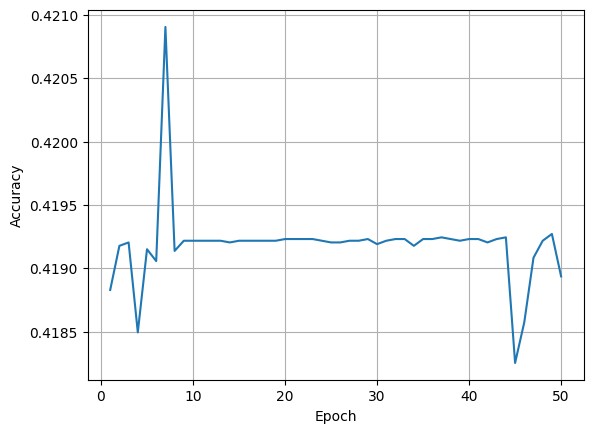

In [45]:
acc = history.history['accuracy']
epochs = np.array(list(range(1, 51)))
plt.plot(epochs, acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [58]:
def predict(model, X_test):
    X_test_indices = sentence_to_indices(X_test, words_to_idx, maxLen)
    y_test_pred = model.predict(X_test_indices)
    predicted_label = np.argmax(y_test_pred)
    if (predicted_label == 0): return("Neutral")
    elif (predicted_label == 1): return("Negative")
    return("Positive")

In [63]:
y_pred_val = model.predict(X_val_indices)
for idx, res in enumerate(y_pred_val):
    temp = np.argmax(res)
    print(idx, res)
    if (temp ==0): continue
    elif (temp == 1): print(f"Predicted 'Negative' for '{X_val[idx]}'")
    else: print(f"Predicted 'Positive' for '{X_val[idx]}'")

 1/32 [..............................] - ETA: 1s

32/32 [==============================] - 1s 37ms/step
0 [0.41864178 0.29921606 0.28214216]
1 [0.41898552 0.29860252 0.28241196]
2 [0.41898552 0.2986026  0.28241184]
3 [0.41899106 0.2985918  0.2824172 ]
4 [0.4188752  0.29879844 0.28232637]
5 [0.41821364 0.30002016 0.28176618]
6 [0.41899508 0.29858482 0.28242004]
7 [0.41896316 0.29864436 0.28239238]
8 [0.41898715 0.29859942 0.28241342]
9 [0.4189966  0.29858318 0.2824202 ]
10 [0.41898206 0.29860923 0.28240857]
11 [0.4189977  0.29858038 0.28242192]
12 [0.4189923  0.29858992 0.28241777]
13 [0.4189961  0.29858258 0.2824213 ]
14 [0.4189877  0.2985981  0.28241408]
15 [0.41836274 0.29972327 0.281914  ]
16 [0.4189978  0.29858124 0.282421  ]
17 [0.41899765 0.29858056 0.28242177]
18 [0.418987   0.29859957 0.2824133 ]
19 [0.41898364 0.29860598 0.28241026]
20 [0.41899425 0.2985856  0.28242013]
21 [0.4189957  0.29858753 0.2824168 ]
22 [0.4182274  0.29997998 0.2817926 ]
23 [0.4189474  0.298673   0.28237963]
24 [0.41899216 0.29858944 0.28241837]
25 [0.